# <center>Analysis of How the State Update Function can be Improved</center>

This file is an interactive notebook to analyze the data obtained from tests.<br>
It focuses on how changing how the state is updated improves the agent. The improved agent discards a hyperstate if it must backtrack more than 1 state. It will start again from the base state if there are 0 hypergames left in the state. The branching factor has been set to 2 to improve exploration of the search space - By ignoring backtracking, there is no longer the drawback of high probability of backtracking *forever*.

I will be using kriegTTT_5x5 because this is a more complex game. 

Original Agent Params:<br>
numHyperGames = 50<br>
numHyperBranches = 25<br>
numProbes = 4

Improved Agent Params:<br>
numHyperGames = 50<br>
numHyperBranches = 2<br>
numProbes = 4

## Reading in the Data

First the match data must be read in.

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import statistics
np.random.seed(42)

# Read in the csv files
numNames = ['BasicTest', 'AnytimeTest4Probes']
data = list()

for idx, name in enumerate(numNames):
    file_name = 'testOutput/kriegTTT_5x5/' + name + '/testOutput.csv'
    data.append(pd.DataFrame)
    data[idx] = pd.read_csv(file_name, header=0)

# Print the first 5 rows of the data
for game in data:
    display(game.head())

,match_id,game_name,gdl_version,timestamp,startclock,playclock,sight_of,num_steps,role_1,player_1,player_1_score,role_2,player_2,player_2_score
0,hypertest_5x5_300_0,kriegTTT_5x5,2,1590537010157,10,300,OPLAYER,6,xplayer,HYPER,100,oplayer,IMPRANDOM,0
1,hypertest_5x5_300_2,kriegTTT_5x5,2,1590537952271,10,300,OPLAYER,5,xplayer,HYPER,100,oplayer,IMPRANDOM,0
2,hypertest_5x5_300_3,kriegTTT_5x5,2,1590538147553,10,300,OPLAYER,5,xplayer,HYPER,100,oplayer,IMPRANDOM,0
3,hypertest_5x5_300_5,kriegTTT_5x5,2,1590538908502,10,300,OPLAYER,5,xplayer,HYPER,100,oplayer,IMPRANDOM,0
4,hypertest_5x5_300_6,kriegTTT_5x5,2,1590539037323,10,300,OPLAYER,5,xplayer,HYPER,100,oplayer,IMPRANDOM,0


,match_id,game_name,gdl_version,timestamp,startclock,playclock,sight_of,num_steps,role_1,player_1,player_1_score,role_2,player_2,player_2_score
0,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,2,1593140163314,10,300,OPLAYER,15,xplayer,AHYPER,100,oplayer,XXXX,0
1,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,2,1593140184403,10,300,OPLAYER,4,xplayer,AHYPER,100,oplayer,XXXX,0
2,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,2,1593140242407,10,300,OPLAYER,6,xplayer,AHYPER,100,oplayer,XXXX,0
3,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,2,1593140263706,10,300,OPLAYER,4,xplayer,AHYPER,100,oplayer,XXXX,0
4,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,2,1593140387127,10,300,OPLAYER,8,xplayer,AHYPER,0,oplayer,XXXX,100


Next, the move data should be read in for each match

*Note: time_to_update and time_to_select_move are in milliseconds*

In [74]:
move_list_games = list()
for idx, name in enumerate(numNames):
    file_name_prefix = 'testOutput/kriegTTT_5x5/' + name + '/moveset/'
    temp_move_list = list()
    for match_name in data[idx]['match_id']:
        file_name = file_name_prefix + match_name + '.csv'
        if name != 'BasicTest':
            temp_move_list.append(pd.read_csv(file_name, names=['match_id','game_name','step','role_name','player_name','count_hypergames','num_probes','time_to_update','time_to_select_move','move_chosen']))
        else :
            temp_move_list.append(pd.read_csv(file_name, header=0))
    move_list_games.append(temp_move_list)

# Verify by printing the head of the first game
for move_list in move_list_games:
    display(move_list[0])

,match_id,game_name,step,role_name,player_name,count_hypergames,num_probes,time_to_update,time_to_select_move,move_chosen
0,hypertest_5x5_300_0,kriegTTT_5x5,0,OPLAYER,imprandom,1,4,21,0,(MARK 1 1 )
1,hypertest_5x5_300_0,kriegTTT_5x5,0,XPLAYER,hyper,1,4,21,2163,(MARK 2 3 )
2,hypertest_5x5_300_0,kriegTTT_5x5,1,OPLAYER,imprandom,24,4,40,0,(MARK 1 2 )
3,hypertest_5x5_300_0,kriegTTT_5x5,1,XPLAYER,hyper,24,4,30,39741,(MARK 5 4 )
4,hypertest_5x5_300_0,kriegTTT_5x5,2,OPLAYER,imprandom,50,4,81,0,(MARK 5 3 )
5,hypertest_5x5_300_0,kriegTTT_5x5,2,XPLAYER,hyper,50,4,79,73497,(MARK 3 2 )
6,hypertest_5x5_300_0,kriegTTT_5x5,3,OPLAYER,imprandom,50,4,470,0,(MARK 3 1 )
7,hypertest_5x5_300_0,kriegTTT_5x5,3,XPLAYER,hyper,50,4,448,64486,(MARK 2 5 )
8,hypertest_5x5_300_0,kriegTTT_5x5,4,OPLAYER,imprandom,50,4,8229,0,(MARK 4 2 )
9,hypertest_5x5_300_0,kriegTTT_5x5,4,XPLAYER,hyper,50,4,8389,57280,(MARK 2 2 )


,match_id,game_name,step,role_name,player_name,count_hypergames,num_probes,time_to_update,time_to_select_move,move_chosen
0,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,0,OPLAYER,xxxx,1,16,6,0,(MARK 5 4 )
1,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,0,XPLAYER,ahyper,1,4,5,1969,(MARK 2 1 )
2,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,1,OPLAYER,xxxx,2,16,6,0,(MARK 2 5 )
3,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,1,XPLAYER,ahyper,2,4,5,2983,(MARK 4 3 )
4,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,2,OPLAYER,xxxx,4,16,7,0,(MARK 1 4 )
5,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,2,XPLAYER,ahyper,4,4,6,5645,(MARK 1 2 )
6,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,3,OPLAYER,xxxx,8,16,11,0,(MARK 2 3 )
7,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,3,XPLAYER,ahyper,8,4,10,9255,(MARK 2 2 )
8,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,4,OPLAYER,xxxx,12,16,394,0,(MARK 4 4 )
9,hypertest_5x5_AnytimeTest_numHyperBranches2_nu...,kriegTTT_5x5,4,XPLAYER,ahyper,16,4,19,16822,(MARK 1 3 )


## Analysis of Data

### Overall Agent Results

The average score of the agent will be calculated across all games

The win/draw rate for the agent "HYPER" playing the game "kriegTTT_5x5" with BasicTest probes is 100.00% for 35 games
The win/draw rate for the agent "AHYPER" playing the game "kriegTTT_5x5" with AnytimeTest4Probes probes is 76.00% for 50 games


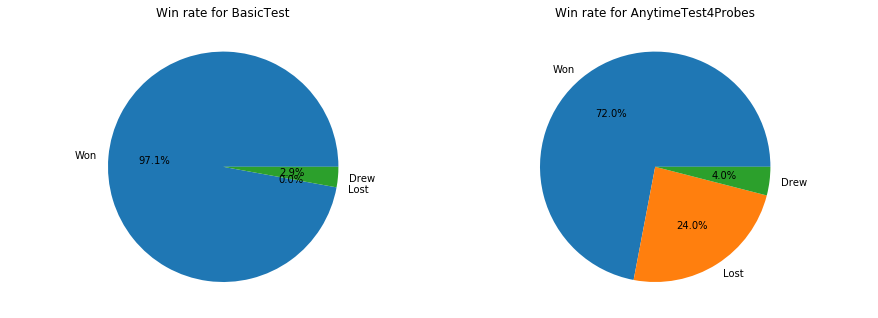

In [103]:
count_games_completed = list()
for idx, game in enumerate(data):
    total_score = data[idx]['player_1_score'][data[idx]['player_1_score'] >= 50].count() * 100
    total_count = len(data[idx]['player_1_score'])
    count_games_completed.append(total_count)
    print(f"The win/draw rate for the agent \"" + str(data[idx]['player_1'][0]) + "\" playing the game \"" + str(data[idx]['game_name'][0]) + "\" with " + str(numNames[idx]) + f" probes is {(total_score/total_count):.2f}% for " + str(total_count) + " games")

# Display a pie chart
fig = plt.figure()
data_len = len(data)
win_count = list()
for idx, game in enumerate(data):
    ax = fig.add_axes([(data_len - idx)%2,math.ceil((data_len - idx)/2),1,1])
    ax.axis('equal')
    ax.set_title('Win rate for ' + str(numNames[idx]))
    result = ['Won', 'Lost', 'Drew']
    game_count = [len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 0)]), len(game[(game['player_1_score'] == 0) & (game['player_2_score'] == 100)]), len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 100)| (game['player_1_score'] == 50) & (game['player_2_score'] == 50)])]
    win_count.append(game_count[0])
    ax.pie(game_count, labels = result,autopct='%1.1f%%')
plt.show()

It is now worth looking into how performance degrades with fewer probes.

First I will consider the number of games that can be completed without error compared to the number of probes.

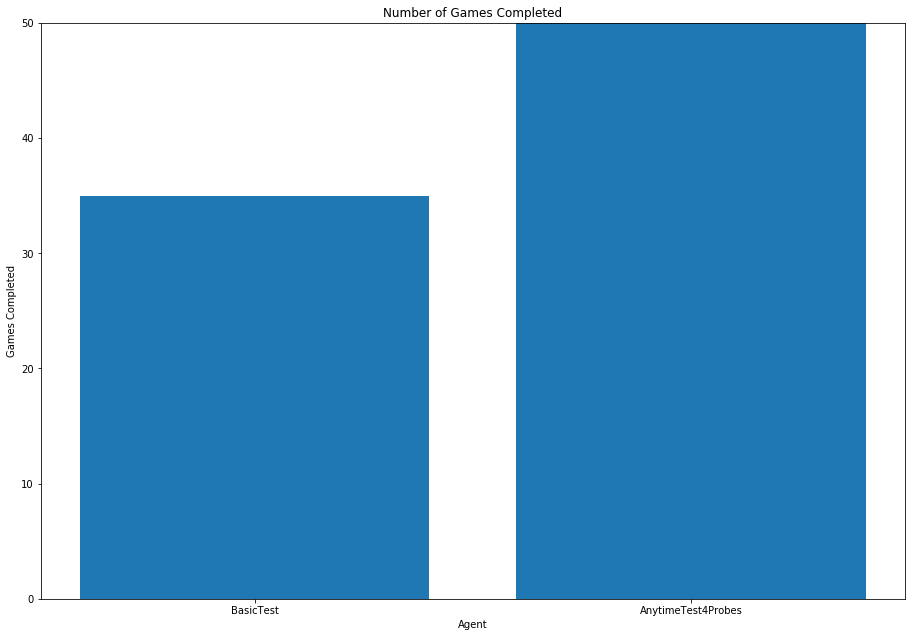

In [98]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,2,2], label='state_update')
ax1.set_title('Number of Games Completed')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Games Completed')
ax1.set_yscale('linear')
ax1.set_ylim([0,50])
ax1.bar(numNames, count_games_completed)
plt.show()

I will now consider whether the number of games won

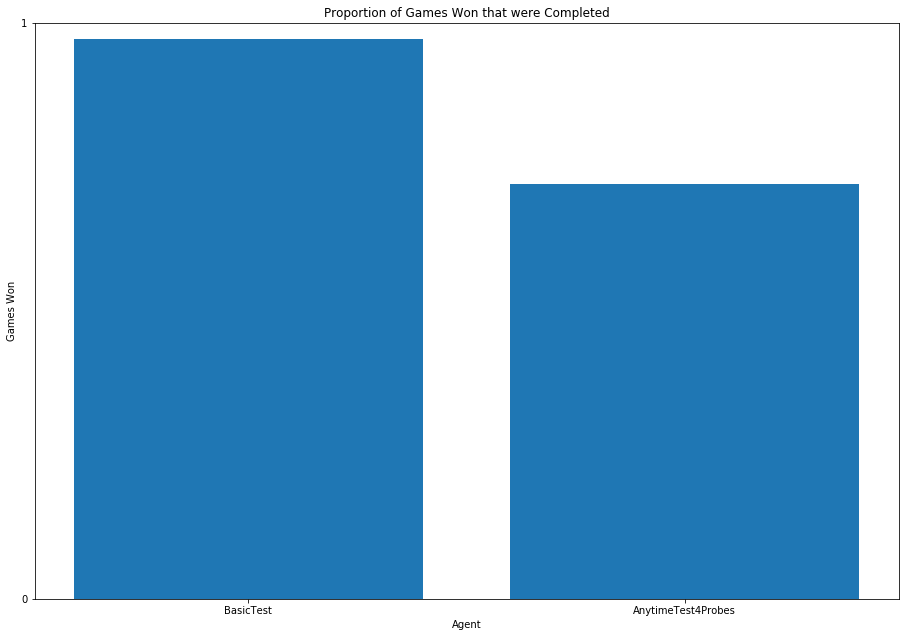

In [99]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,2,2])
ax1.set_title('Proportion of Games Won that were Completed')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Games Won')
ax1.set_yscale('linear')
ax1.set_yticks(range(0,2,1))
ax1.set_ylim([0,1])
ax1.bar(numNames, np.divide(win_count,count_games_completed))
plt.show()

I will now consider the games that were not completed as losses and see how this affects the final score

The win/draw rate for the agent "HYPER" playing the game "kriegTTT_5x5" with BasicTest probes is 70.00% for 50 games
The win/draw rate for the agent "AHYPER" playing the game "kriegTTT_5x5" with AnytimeTest4Probes probes is 76.00% for 50 games


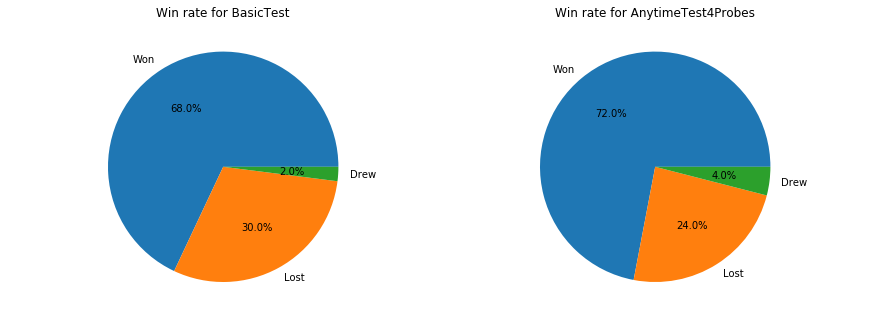

In [112]:
count_games_completed = list()
for idx, game in enumerate(data):
    total_score = data[idx]['player_1_score'][data[idx]['player_1_score'] >= 50].count() * 100
    total_count = 50
    count_games_completed.append(total_count)
    print(f"The win/draw rate for the agent \"" + str(data[idx]['player_1'][0]) + "\" playing the game \"" + str(data[idx]['game_name'][0]) + "\" with " + str(numNames[idx]) + f" probes is {(total_score/total_count):.2f}% for " + str(total_count) + " games")

# Display a pie chart
fig = plt.figure()
data_len = len(data)
win_count = list()
for idx, game in enumerate(data):
    ax = fig.add_axes([(data_len - idx)%2,math.ceil((data_len - idx)/2),1,1])
    ax.axis('equal')
    ax.set_title('Win rate for ' + str(numNames[idx]))
    result = ['Won', 'Lost', 'Drew']
    if data[idx]['player_1'][0] == 'HYPER':
        game_count = [(len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 0)])), (len(game[(game['player_1_score'] == 0) & (game['player_2_score'] == 100)])) + 15, (len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 100)]))]
    else:
        game_count = [len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 0)]), len(game[(game['player_1_score'] == 0) & (game['player_2_score'] == 100)]), len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 100) | (game['player_1_score'] == 50) & (game['player_2_score'] == 50)])]
    win_count.append(game_count[0])
    ax.pie(game_count, labels = result,autopct='%1.1f%%')
plt.show()

I will now consider the average time taken to win for various hypergames.

*Note: It is +1 because step increments from 0*

BasicTest
	Mean steps to win: 4
	Median steps to win: 5.0
AnytimeTest4Probes
	Mean steps to win: 7
	Median steps to win: 6.0


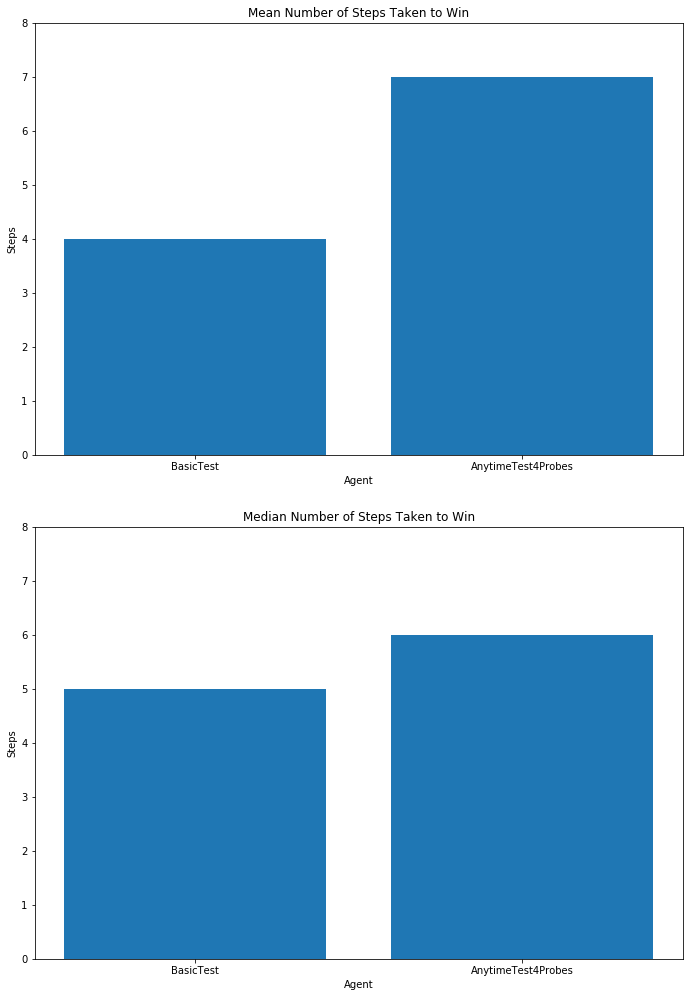

In [113]:
# Calculate the average number of steps taken to win for each hypergame
steps_to_win_list = list()
for idx, (move_list, game) in enumerate(zip(move_list_games, data)):
    game_steps_to_win_list = list()
    winning_games = game[((game['player_1_score'] == 100) & (game['player_2_score'] == 0))] 
    winning_games_list = winning_games['match_id'].tolist()
    for moves in move_list:
        if(moves['match_id'][0] in winning_games_list):
            move_length = len(moves['match_id'])
            game_steps_to_win_list.append(moves['step'][move_length - 1] + 1)
    steps_to_win_list.append(game_steps_to_win_list)

# Print steps to win
mean_steps_to_win = list()
median_steps_to_win = list()
for idx, game_steps_to_win in enumerate(steps_to_win_list):
    mean = statistics.mean(game_steps_to_win)
    median = statistics.median(game_steps_to_win)
    print(f'{numNames[idx]}')
    print(f'\tMean steps to win: {mean}')
    print(f'\tMedian steps to win: {median}')
    mean_steps_to_win.append(mean)
    median_steps_to_win.append(median)

# Graph steps to win
fig = plt.figure()
ax1 = fig.add_axes([0,0,1.5,1.5])
ax1.set_title('Mean Number of Steps Taken to Win')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Steps')
ax1.set_yscale('linear')
ax1.set_yticks(range(0,10,1))
ax1.set_ylim([0,8])
ax1.bar(numNames, mean_steps_to_win)

ax2 = fig.add_axes([0,-1.75,1.5,1.5])
ax2.set_title('Median Number of Steps Taken to Win')
ax2.set_xlabel('Agent')
ax2.set_ylabel('Steps')
ax2.set_yscale('linear')
ax2.set_yticks(range(0,10,1))
ax2.set_ylim([0,8])
ax2.bar(numNames, median_steps_to_win)

plt.show()

### Move Results

Calculating the average move time per game.
This is expected to grow with the depth of the game and is expected to be different for the state update and the move selection.

In [114]:
class Tracker:
    '''
    Tracker tracks the average time for each move of each game played
    '''
    def __init__(self):
        self.time_sum = 0
        self.num_moves = 0
        self.times = list()
    
    def __str__(self):
        return "time_sum: " + str(self.time_sum) + " ms\n\tnum_moves: " + str(self.num_moves) + "\n\tmean_time: " + str(statistics.mean(self.times)) + "\n\tmedian_time: " + str(statistics.median(self.times)) + " ms\n\ttimes (ms): " + str(self.times)
    
    def addMove(self, num):
        self.time_sum += num
        self.num_moves+=1
        self.times.append(num)
    
    def getMeanTime(self):
        return statistics.mean(self.times)
    
    def getMedianTime(self):
        return statistics.median(self.times)

# Add the results for each move of each game played to a list of trackers for the update and select move times for the chosen player
time_to_update_list = list()
time_to_select_move_list = list()
for idx, (move_list, game) in enumerate(zip(move_list_games, data)):
    temp_time_to_update_list = list()
    temp_time_to_select_move_list = list()
    player_name = game['role_1'][0].upper()
    for move_set in move_list:
        for index, move_row in move_set.iterrows():
            if move_row['role_name'] == player_name:
                if move_row['step'] > len(temp_time_to_update_list) - 1:
                    temp_time_to_update_list.append(Tracker())
                    temp_time_to_select_move_list.append(Tracker())
                temp_time_to_update_list[move_row['step']].addMove(move_row['time_to_update'])
                temp_time_to_select_move_list[move_row['step']].addMove(move_row['time_to_select_move'])
    time_to_update_list.append(temp_time_to_update_list)
    time_to_select_move_list.append(temp_time_to_select_move_list)

# Print the data
for game_num, (game_time_to_update_list, game_time_to_select_move_list) in enumerate(zip(time_to_update_list, time_to_select_move_list)):
    print(str(numNames[game_num]))
    for idx, (update_step, select_step) in enumerate(zip(game_time_to_update_list, game_time_to_select_move_list)):
        print('\tStep: ' + str(idx) + "\n")
        print('\tTime taken to update states:')
        print('\t' + str(update_step)  + "\n")
        print('\tTime taken to select move:')
        print('\t' + str(select_step)  + "\n\n\n")

BasicTest
	Step: 0

	Time taken to update states:
	time_sum: 69 ms
	num_moves: 35
	mean_time: 1.9714285714285715
	median_time: 0 ms
	times (ms): [21, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 6, 0, 8, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 2]

	Time taken to select move:
	time_sum: 68835 ms
	num_moves: 35
	mean_time: 1966.7142857142858
	median_time: 1920 ms
	times (ms): [2163, 2094, 2070, 1913, 1792, 1850, 2059, 2122, 2013, 1835, 1937, 1913, 1896, 1811, 2006, 2132, 1870, 1916, 1914, 1833, 2060, 1911, 1849, 2179, 1892, 1933, 2022, 1945, 1910, 1920, 2231, 1872, 1962, 1911, 2099]



	Step: 1

	Time taken to update states:
	time_sum: 1038 ms
	num_moves: 35
	mean_time: 29.65714285714286
	median_time: 31 ms
	times (ms): [30, 29, 38, 32, 15, 31, 41, 39, 31, 31, 31, 31, 21, 32, 31, 32, 31, 32, 31, 31, 31, 32, 32, 33, 33, 31, 22, 16, 22, 31, 31, 31, 21, 22, 30]

	Time taken to select move:
	time_sum: 1152797 ms
	num_moves: 35
	mean_time: 32937.05714285714
	median_time: 34402 ms
	times

Now I will graph the findings

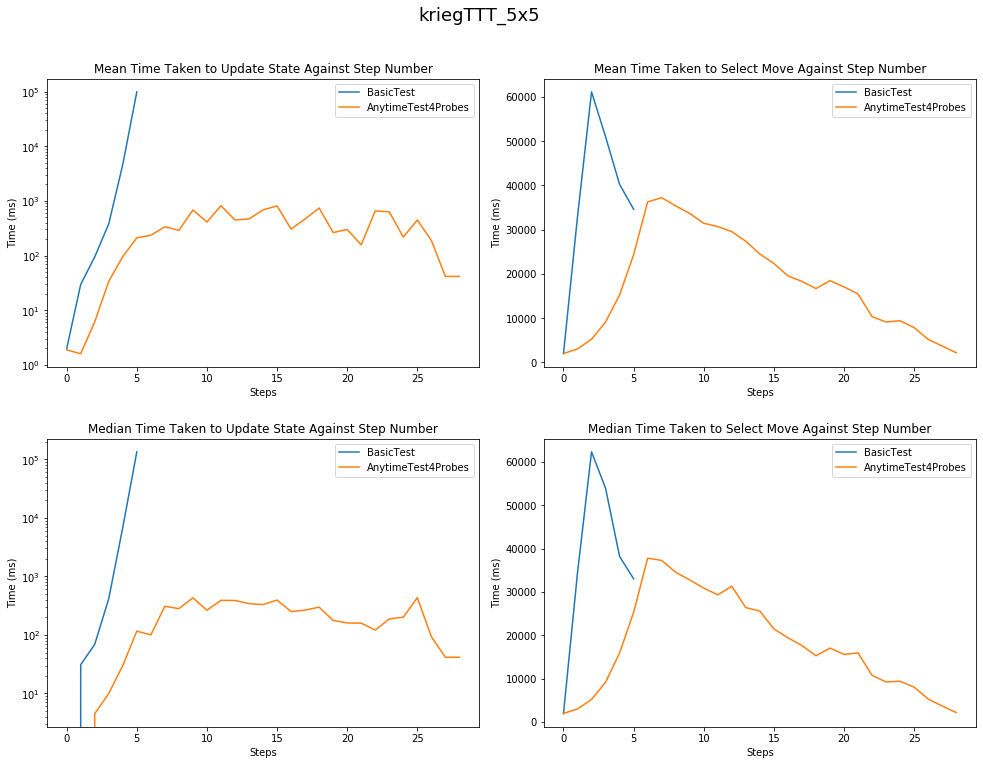

In [115]:
# Add the data to an array
mean_state_update_times = list()
mean_move_select_times = list()
median_state_update_times = list()
median_move_select_times = list()
for game_num, (game_time_to_update_list, game_time_to_select_move_list) in enumerate(zip(time_to_update_list, time_to_select_move_list)):
    temp_mean_state_update_times = list()
    temp_mean_move_select_times = list()
    temp_median_state_update_times = list()
    temp_median_move_select_times = list()
    for update_step, select_step in zip(game_time_to_update_list, game_time_to_select_move_list):
        temp_mean_state_update_times.append(update_step.getMeanTime())
        temp_mean_move_select_times.append(select_step.getMeanTime())
        temp_median_state_update_times.append(update_step.getMedianTime())
        temp_median_move_select_times.append(select_step.getMedianTime())
    mean_state_update_times.append(temp_mean_state_update_times)
    mean_move_select_times.append(temp_mean_move_select_times)
    median_state_update_times.append(temp_median_state_update_times)
    median_move_select_times.append(temp_median_move_select_times)

# Put into graphs
fig = plt.figure()
fig.suptitle(str(data[0]['game_name'][0]), x=1, y=2.5, fontsize=18)

# Draw mean graph for State Update
ax1 = fig.add_axes([0,1.25,1,1], label='state_update_mean')
ax1.set_title('Mean Time Taken to Update State Against Step Number')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Time (ms)')
ax1.set_yscale('log')
for idx, game_mean_state_update_times in enumerate(mean_state_update_times):
    ax1.plot(game_mean_state_update_times, label=str(numNames[idx]))
ax1.legend()

# Draw mean graph for Move Select
ax2 = fig.add_axes([1.15,1.25,1,1], label='move_select_mean')
ax2.set_title('Mean Time Taken to Select Move Against Step Number')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Time (ms)')
ax2.set_yscale('linear')
for idx, game_mean_move_select_times in enumerate(mean_move_select_times):
    ax2.plot(game_mean_move_select_times, label=str(numNames[idx]))
ax2.legend()

# Draw median graph for State Update
ax3 = fig.add_axes([0,0,1,1], label='state_update_median')
ax3.set_title('Median Time Taken to Update State Against Step Number')
ax3.set_xlabel('Steps')
ax3.set_ylabel('Time (ms)')
ax3.set_yscale('log')
for idx, game_median_state_update_times in enumerate(median_state_update_times):
    ax3.plot(game_median_state_update_times, label=str(numNames[idx]))
ax3.legend()

# Draw median graph for Move Select
ax4 = fig.add_axes([1.15,0,1,1], label='move_select_median')
ax4.set_title('Median Time Taken to Select Move Against Step Number')
ax4.set_xlabel('Steps')
ax4.set_ylabel('Time (ms)')
ax4.set_yscale('linear')
for idx, game_median_move_select_times in enumerate(median_move_select_times):
    ax4.plot(game_median_move_select_times, label=str(numNames[idx]))
ax4.legend()

plt.show()

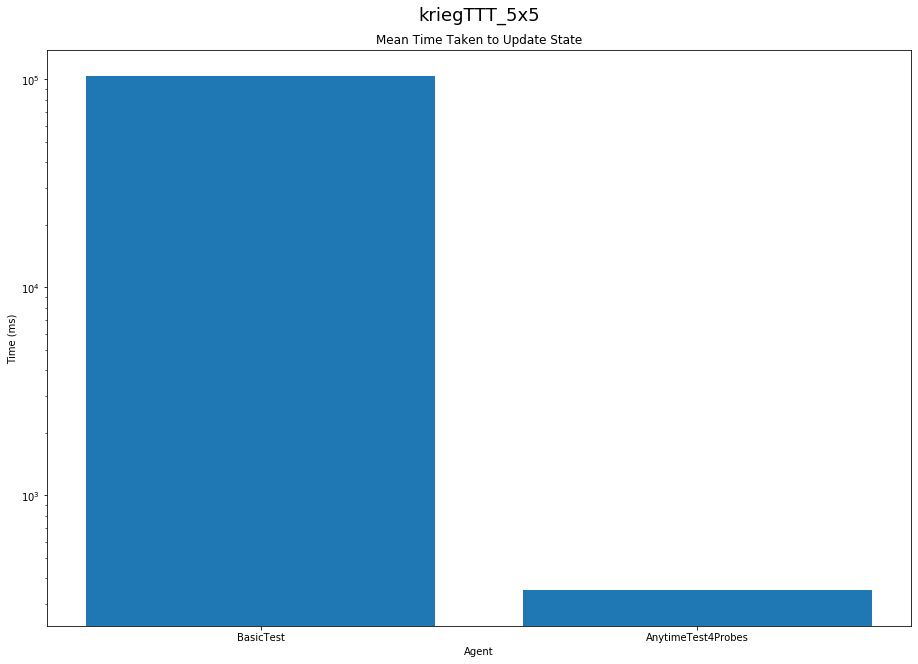

In [118]:
sum_game_mean_state_update_times = list()
for idx, game_mean_state_update_times in enumerate(mean_state_update_times):
    sum_game_mean_state_update_times.append(sum(game_mean_state_update_times[:6]))
    
# Put into graphs
fig = plt.figure()
fig.suptitle(str(data[0]['game_name'][0]), x=1, y=2.15, fontsize=18)

# Draw mean graph for State Update
ax1 = fig.add_axes([0,0,2,2])
ax1.set_title('Mean Time Taken to Update State')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Time (ms)')
ax1.set_yscale('log')
ax1.bar(numNames, sum_game_mean_state_update_times)

plt.show()
    
# sum_game_mean_state_update_times